In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Read the Merged file

In [6]:
def read_file(file):
    f = open(file, 'r', encoding='utf-8')
    lines = f.readlines()
    data = '\t'.join([line.strip() for line in lines])
    return data

data = read_file('merged-content.txt')

# Clean the Read file

In [7]:
import nltk
nltk.download('stopwords')

import re
import string
from nltk.corpus import stopwords
import pandas as pd

def clean_doc(doc):
    
    #replace -- with a space
    doc = doc.replace('-',' ')
    
    #replace -- with a space
    doc = doc.replace('.',' ')
    
    #split into tokens by white space
    tokens = doc.split()
    
    # prepare for char filtering
    re_punc = re.compile('[%s]'%re.escape(string.punctuation))
    
    #remove punctuation from words
    tokens = [re_punc.sub('',w) for w in tokens]
    
    #remove remaining tokens that are not alphanumerics
    tokens = [word for word in tokens if word.isalpha()]
    
    #make lower case
    tokens = [word.lower() for word in tokens]
    
    #remove stop words & words which appear less than 1 times
    stops = set(stopwords.words("english"))
    tokens = [word for word in tokens if not word in stops and len(word)>=3]

    return tokens

tokens = clean_doc(data)
    
print (tokens[0])
print ('Number of tokens are ', len(tokens))
print ('Number of unique tokens is ', len(set(tokens)))

[nltk_data] Downloading package stopwords to C:\Users\Aditya
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


term
Number of tokens are  70548
Number of unique tokens is  6852


In [8]:
MAX_WORDS=80000
BATCH_SIZE=16
EPOCHS=2
OOV_TOKEN=0
EMBEDDING_DIM = 100
MAX_SEQ_LENGTH=20
VALIDATION_SPLIT_RATIO= 0.3
LSTM_UNITS=64

# Generate Sequences

    - This method takes in bunch of tokens and then converts those tokens into sequences. The idea here is that we create
    sequences of 21 tokens (words) each and then feed each sequence one at a time to the network. each word in the sequence represents a value at a given timesteps. All words in effect become the features

In [9]:
def generate_sequences(size, tokens):
    sequences = list()
    size_seq = size + 1
    for i in range (0, len(tokens)-size):
        seq = tokens[i:size_seq+i]
        line = ' '.join(seq)
        sequences.append(line)
        
    print ('Total number of sequenes is ', len(sequences))
    return sequences

sequences = generate_sequences(MAX_SEQ_LENGTH, tokens)

Total number of sequenes is  70528


# Save generated sequences in new file

In [10]:
def save_sequences(filename, sequences):
    
    file = open(filename,'w',encoding='utf-8')
    lines = '\n'.join(sequences)
    file.write(lines)
    file.close()
    
save_sequences('merged-content-cleaned.txt', sequences)

# Read cleaned sequences from file

In [11]:
def read_sequences(file):
    f = open(file, 'r', encoding='utf-8')
    lines = f.read()
    return lines

lines = read_sequences('merged-content-cleaned.txt')
lines = lines.split('\n')

### Tokenize comments

In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_WORDS, oov_token=OOV_TOKEN, filters='')
tokenizer.fit_on_texts(lines)
word2Idx = tokenizer.word_index
VOCAB_LEN = len (word2Idx)+1

print ('Found %d unique words'%(len(word2Idx)))
print (word2Idx['isa'])

sequences = tokenizer.texts_to_sequences(lines)
padded_input_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=MAX_SEQ_LENGTH)

print ('Created %d padded input sequences'%(len(padded_input_sequences)))

Found 6853 unique words
59
Created 70528 padded input sequences


In [14]:
sequences = np.array(sequences)
X = padded_input_sequences[:,:MAX_SEQ_LENGTH]
y = padded_input_sequences[:,-1]
y = tf.keras.utils.to_categorical(y, num_classes=VOCAB_LEN)

#### Load GloVe embeddings

In [15]:
embeddings_index = {}

f = open ('glove.6B.100d.txt','r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word]=coefs

f.close()
print ('Found %s word embeddings'%(len(embeddings_index)))

Found 400000 word embeddings


In [16]:
num_words = min (MAX_WORDS, VOCAB_LEN)
print ('Min words to be considered are %d'%(num_words))

loaded_embeddings_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2Idx.items():
    if (i<num_words):
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index[word]
            loaded_embeddings_matrix[i] = embedding_vector

print (loaded_embeddings_matrix.shape)

Min words to be considered are 6854
(6854, 100)


# Configure Callbacks which would be executed during the training phase

### Build Model

In [18]:
embed_layer = tf.keras.layers.Embedding(input_dim = num_words,
                               output_dim = EMBEDDING_DIM,
                               input_length=MAX_SEQ_LENGTH, 
                               embeddings_initializer=tf.keras.initializers.Constant(loaded_embeddings_matrix),
                               trainable=True)

In [23]:
input_ = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,))

x = embed_layer(input_)

conv1d_1 = tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu')
x = conv1d_1(x)

batchnorm_1 = tf.keras.layers.BatchNormalization()
x = batchnorm_1(x)

maxpool_1 = tf.keras.layers.MaxPooling1D(pool_size=5)
x = maxpool_1(x)

#globalmaxpool_1 = tf.keras.layers.GlobalMaxPooling1D()
#x = globalmaxpool_1(x)

lstm_layer_0 = tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True)
x = lstm_layer_0(x)

lstm_layer_1 = tf.keras.layers.LSTM(units=LSTM_UNITS)
x = lstm_layer_1(x)

dense_layer2 = tf.keras.layers.Dense(num_words, activation='softmax')
output = dense_layer2(x)

model = tf.keras.models.Model(input_, output)

model.compile (optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 100)           685400    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 16)            14416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 16)            64        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 16)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 64)             20736     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024 

In [24]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_targets, test_targets = train_test_split (X, y)

In [25]:
history = model.fit (train_sentences, train_targets, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT_RATIO)

W0902 12:44:22.227433  4136 deprecation.py:323] From C:\MachineLearning\anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 37027 samples, validate on 15869 samples
Epoch 1/2
37027/37027 [==============================] - 70s 2ms/sample - loss: 7.6943 - accuracy: 0.0117 - val_loss: 7.4331 - val_accuracy: 0.0142
Epoch 2/2
37027/37027 [==============================] - 57s 2ms/sample - loss: 7.0615 - accuracy: 0.0259 - val_loss: 7.1339 - val_accuracy: 0.0396


### Visualize Training Performance

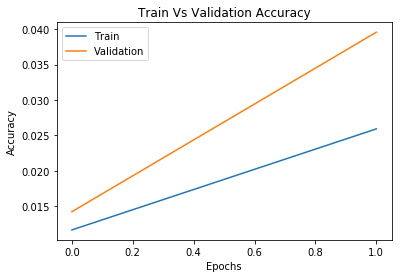

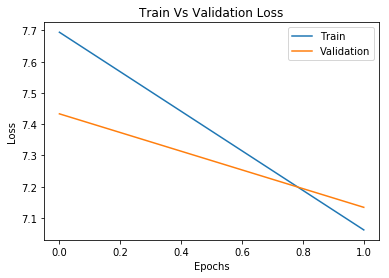

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

## Visualizing Model Accuracy on Training & Validation data
trainAccHistory = history.history['accuracy']
validationAccHistory = history.history['val_accuracy']

plt.plot(trainAccHistory)
plt.plot(validationAccHistory)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Vs Validation Accuracy')
plt.legend(['Train','Validation'])
plt.show()

trainLossHistory = history.history['loss']
validationLossHistory = history.history['val_loss']

plt.plot(trainLossHistory)
plt.plot(validationLossHistory)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Vs Validation Loss')
plt.legend(['Train','Validation'])
plt.show()

## Prove Quality of Word Embeddings

### Create Matrix of Word Embeddings in our Vocab

    - Read words from our word dictionary
    - Read the embeddings weights from the embedding layer
    - For each word in the dictionary read it's embedding weight and add to a dictionary

In [31]:
import numpy as np
embeddings_index = {}

# get weights from the embedding layer
embeddings = model.layers[1].get_weights()[0]

print ('Shape of weights from embedding layer is ', embeddings.shape)
print ('Size of vocab is ', len(word2Idx))

for word, i in word2Idx.items():
    if (i<len(embeddings)):
        embeddings_index[word] =  embeddings[i]

Shape of weights from embedding layer is  (6854, 100)
Size of vocab is  6853


#### Save the Reviews Embedding

In [32]:
def save_list (p_embeddings, filename):
    #open file
    file = open (filename, 'w', encoding='utf-8')
    
    for word, i in word2Idx.items():
        if (i<len(embeddings)):
            embed = embeddings[i, :]
            file.write('%s %s\n' % (word, ' '.join(map(str, embed))))
        
    #close file
    file.close()
    
save_list(embeddings_index, 'am.embeddings.100D.txt')

# Leverage Embeddings to find similar words

In [33]:
from gensim.scripts.glove2word2vec import glove2word2vec

#load the GloVe word embeddings file which has a 100 dimension representation for each word. Convert that into a word2vec supported format
glove2word2vec('am.embeddings.100D.txt','word2vec.am.embeddings.100D.txt')

from gensim.models import KeyedVectors

# load the wordvec file
lword2vecmodel = KeyedVectors.load_word2vec_format('word2vec.am.embeddings.100D.txt')

# most similar words
print (lword2vecmodel.most_similar(['fidelity']))

W0902 12:48:20.245780  4136 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead
W0902 12:48:20.268776  4136 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead
W0902 12:48:20.270788  4136 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead
W0902 12:48:20.271777  4136 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead
W0902 12:48:20.526785  4136 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead
C:\MachineLearning\anaconda\lib\site-packages\gensim\models\keyedvectors.py:2373: RuntimeWarning: invalid value encountered in true_divide
  return (m / dist).astype(REAL)


[('portfolio', 0.5701218247413635), ('asset', 0.5660609006881714), ('merrill', 0.5588669180870056), ('mutual', 0.5465114116668701), ('equity', 0.5407130718231201), ('corporate', 0.5401830673217773), ('brokerage', 0.5350320339202881), ('lynch', 0.5161300897598267), ('morningstar', 0.5158453583717346), ('investment', 0.5079617500305176)]


#### Visualize embeddings using PCA

    - In tour word embedding there are some 80K words with 100 dimensional embedding. We will select just 50 words and try to visualize them after doing a dimension reduction via PCA

C:\MachineLearning\anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


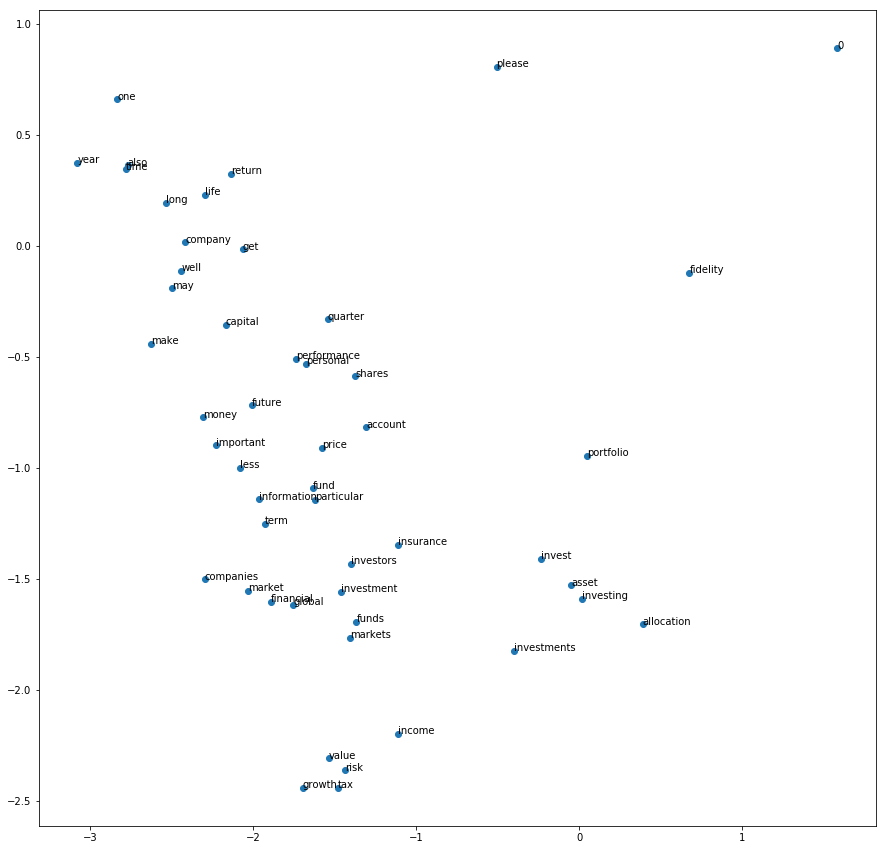

In [34]:
lvocab = lword2vecmodel.wv.vocab
words = []
for i, word in enumerate(lvocab):
    words.append(word)

X = lword2vecmodel[lvocab]

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

z = PCA(n_components=2)
pca_model = z.fit(X)
components = pca_model.transform(X)

num_words_to_show=50

plt.figure(figsize=(15,15))
plt.scatter(components[0:num_words_to_show,0],components[0:num_words_to_show,1])
for i in range(0, num_words_to_show):
    plt.annotate(words[i], xy=(components[i,0],components[i,1]))
plt.show()